In [1]:
!pip install d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.0/125.0 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.2 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successful

In [2]:
import random
import torch
from d2l import torch as d2l

##Synethetic Data Generation

The labels (outputs) are generated using a linear function with some random noise to simulate real-world imperfections.


y=Xw+b+ϵ

where X is the design matrix

For convenience we assume that 𝝐 is drawn from a normal distribution with mean 𝜇 = 0
and standard deviation 𝜎 = 0.01



In [3]:
class SyntheticRegressionData(d2l.DataModule):
  def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000,batch_size=32):
    super().__init__()
    self.save_hyperparameters()
    n = num_train + num_val
    self.X = torch.randn(n, len(w))  #generates an (n × d) matrix, where each row is a random vector from a standard normal distribution (mean = 0, variance = 1). also len(w)=d(number of features)
    noise = torch.randn(n, 1) * noise #torch.randn(n, 1) generates random noise from a standard normal distribution for each example. Multiplying by noise scales the randomness by the specified noise level (default: 0.01).
    self.y = torch.matmul(self.X, w.reshape((-1, 1))) + b + noise





In [4]:
data = SyntheticRegressionData(w=torch.tensor([2, -3.4],dtype=torch.float32), b=4.2)


## Reading the Dataset

Training machine learning models often requires multiple passes over a dataset, grabbing one minibatch of examples at a time. This data is then used to update the model.


In [27]:
@d2l.add_to_class(SyntheticRegressionData)
def get_dataloader(self, train):
  i = slice(0, self.num_train) if train else slice(self.num_train, None)
  return self.get_tensorloader((self.X, self.y), train, i)


In [28]:
train_loader = data.get_dataloader(train=True)


In [29]:
for X_batch, y_batch in train_loader:
    print(X_batch.shape, y_batch.shape)
    break  # Just to check the first batch

torch.Size([32, 2]) torch.Size([32, 1])


In [30]:
class LinearRegressionScratch(d2l.Module):
  def __init__(self,num_inputs,lr,sigma=0.01):
    super().__init__()
    self.save_hyperparameters()
    self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
    self.b = torch.zeros(1, requires_grad=True)


In [31]:
@d2l.add_to_class(LinearRegressionScratch)
def forward(self, X):
    return torch.matmul(X, self.w) + self.b


In [32]:
@d2l.add_to_class(LinearRegressionScratch)
def loss(self, y_hat, y):
  l=((y_hat-y)**2)/2
  return l.mean()

### Optimization Algorithm-Minibatch SGD

At each step, using a minibatch randomly drawn from our dataset, we estimate the gradient of the loss with respect to the parameters. Next, we update the parameters in the direction that may reduce the loss.

We update the parameters in the step method.

The zero_grad() function is used to reset or clear the gradients of the model's parameters after each optimization step.

In [33]:
class SGD(d2l.HyperParameters):
  def __init__(self, params, lr):
    self.save_hyperparameters()

  def step(self):
    for param in self.params:
      param-=self.lr*param.grad
  def zero_grad(self):
    for param in self.params:
      if param.grad is not None:
        param.grad.zero_()

In [34]:
@d2l.add_to_class(LinearRegressionScratch)
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

In [35]:
@d2l.add_to_class(d2l.Trainer)
def prepare_batch(self, batch):
    return batch

In [36]:
@d2l.add_to_class(d2l.Trainer)
def fit_epoch(self):
  self.model.train()
  for batch in self.train_dataloader:
    loss = self.model.training_step(self.prepare_batch(batch))
    self.optim.zero_grad()
    with torch.no_grad():
      loss.backward()
      if self.gradient_clip_val > 0:
        self.clip_gradients(self.gradient_clip_val, self.model)
      self.optim.step()
    self.train_batch_idx += 1
  if self.val_dataloader is None:
    return
  self.model.eval()
  for batch in self.val_dataloader:
    with torch.no_grad():
      self.model.validation_step(self.prepare_batch(batch))
    self.val_batch_idx += 1


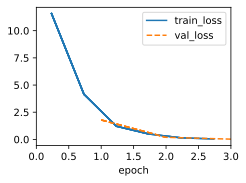

In [37]:
model = LinearRegressionScratch(num_inputs=2, lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

In [38]:
with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'error in estimating b: {data.b - model.b}')

error in estimating w: tensor([ 0.0811, -0.0818])
error in estimating b: tensor([0.1771])
